In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from datasets.utils import get_split_indecies
from tools.utils import set_seed
import numpy as np
import h5py

set_seed(1234)

2023-08-03 22:10:42.323774: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 22:10:42.538428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 22:10:43.417189: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
reload_module("datasets.fabric")
reload_module("datasets.radio_ml_2018")
from datasets.fabric import make_sigmod_ds, DatasetName
ds = make_sigmod_ds(DatasetName.RADIOML_2018)
radioml2018_data_path = cur_dir + "/data/radioml_2018/GOLD_XYZ_OSC.0001_1024.hdf5"
radioml2018_classes_path = cur_dir + "/data/radioml_2018/classes.txt"
ds.load((radioml2018_data_path, radioml2018_classes_path))
split_indecies = get_split_indecies(len(ds.get_snrs()), 0.8, 0.1)


In [3]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName

model_name = "cnn_1d_v012_small_radio_ml18"

cnn_1d_v012_3_configuration = Convolution01xConfiguration(
    input_shape=(1024, 2),
    n_classes=len(ds.get_modulations()),
    output_channels=[32, 48, 64, 96],
    kernel_sizes=[8, 8, 8, 8],
    paddings=["same", "same", "same", "same",],
    max_pool_sizes=[2, 2, 2, 2],
    max_pool_strides=[2, 2, 2, 2],
    avg_size=32,
    dense_sizes=[96],
)

model_configuration = cnn_1d_v012_3_configuration

model = make_sigmod_model(ModelName.CNN_1D_V012, model_configuration)

model.summary()

2023-08-03 22:10:46.678041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-03 22:10:46.767834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-03 22:10:46.768075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 2)]         0         
                                                                 
 CNN0_ (Conv1D)              (None, 1024, 32)          544       
                                                                 
 MAX_POOL_0_ (MaxPooling1D)  (None, 512, 32)           0         
                                                                 
 BN0_ (CustomBatchNorm)      (None, 512, 32)           128       
                                                                 
 CNN_REL0_ (ReLU)            (None, 512, 32)           0         
                                                                 
 CNN1_ (Conv1D)              (None, 512, 48)           12336     
                                                                 
 MAX_POOL_1_ (MaxPooling1D)  (None, 256, 48)           0     

In [4]:
import tensorflow as tf

N_EPOCHS = 25
BATCH_SIZE = 256
BATCH_SIZE = 1024

train_gen = ds.to_keras_generator(split_indecies.train, BATCH_SIZE)
val_gen = ds.to_keras_generator(split_indecies.val, BATCH_SIZE)


def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    return 0.001
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# N_EPOCHS = 16


h = model.fit_generator(
    generator=train_gen,
    validation_data=val_gen,
    
    use_multiprocessing=True,
    workers=12,
    
    epochs=N_EPOCHS,
    callbacks=[lrate]
)


# val_gen = 

/tmp/ipykernel_681828/3135884796.py:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h = model.fit_generator(


Epoch 1/25


2023-08-03 22:11:02.900470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2023-08-03 22:11:05.412806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-03 22:11:06.828827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-03 22:11:06.844417: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x335b4d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-03 22:11:06.844448: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-08-03 22:11:06.864170: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-03 22:11:07.046303: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetim

1996/1996 [==============================] - ETA: 0s - loss: 1.8578 - accuracy: 0.3388

2023-08-03 22:12:55.842039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1996/1996 [==============================] - 129s 61ms/step - loss: 1.8578 - accuracy: 0.3388 - val_loss: 1.7048 - val_accuracy: 0.3811 - lr: 0.0010
Epoch 2/25
1996/1996 [==============================] - 127s 63ms/step - loss: 1.6604 - accuracy: 0.3998 - val_loss: 1.6278 - val_accuracy: 0.4174 - lr: 0.0010
Epoch 3/25
1996/1996 [==============================] - 133s 66ms/step - loss: 1.5846 - accuracy: 0.4357 - val_loss: 1.5366 - val_accuracy: 0.4552 - lr: 0.0010
Epoch 4/25
1996/1996 [==============================] - 140s 70ms/step - loss: 1.5157 - accuracy: 0.4671 - val_loss: 1.4983 - val_accuracy: 0.4777 - lr: 0.0010
Epoch 5/25
1996/1996 [==============================] - 148s 74ms/step - loss: 1.4663 - accuracy: 0.4875 - val_loss: 1.4374 - val_accuracy: 0.4994 - lr: 0.0010
Epoch 6/25
1996/1996 [==============================] - 142s 71ms/step - loss: 1.4198 - accuracy: 0.5058 - val_loss: 1.3956 - val_accuracy: 0.5147 - lr: 0.0010
Epoch 7/25
1996/1996 [=============================

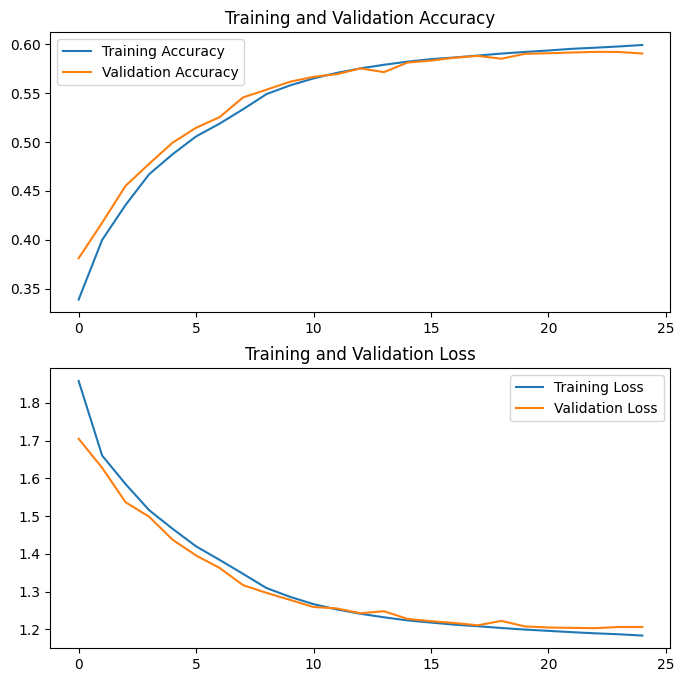

In [6]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
plot_train(h.history)

In [8]:
cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

NameError: name 'splitted_radioml_ds' is not defined

In [5]:
# radioml2018_path = cur_dir + "/data/radioml_2018/GOLD_XYZ_OSC.0001_1024.hdf5"
# print(radioml2018_path)

# with h5py.File(radioml2018_path, 'r') as f:
#     print(f"Keys: {f.keys()}")
#     group_keys = list(f.keys())

#     # get the object type for a_group_key: usually group or dataset
#     for i in range(len(group_keys)):
#         print(type(f[group_keys[i]])) 
#         print(f[group_keys[i]].shape)
#         print(f[group_keys[i]])

#     x_ds_slice = f[group_keys[0]][:1000]
#     y_ds = f[group_keys[1]][()]
#     z_ds = f[group_keys[2]][()]
#     # If a_group_key is a group name, 
#     # this gets the object names in the group and returns as a list
#     # data = list(f[a_group_key])

#     # If a_group_key is a dataset name, 
#     # this gets the dataset values and returns as a list
#     # data = list(f[a_group_key])
#     # preferred methods to get dataset values:
#     # ds_obj = f[a_group_key]      # returns as a h5py dataset object
#     # ds_arr = f[a_group_key][()]  # returns as a numpy array

In [6]:
# print(np.unique(z_ds))
# print(y_ds[500000])
# print(x_ds_slice)